<a href="https://colab.research.google.com/github/vishnu921/damage_detection_using_deep_learning/blob/main/damage_detection_using_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import platform
print("Python version:", platform.python_version())

import sys
import os

import tensorflow as tf
print("tensorflow version:",tf.__version__)

import numpy as np
print("numpy version:",np.__version__)

import cv2
print("cv2 version:",cv2.__version__)

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
print("matplotlib version:",matplotlib.__version__)

import pandas as pd
print("pandas version:",pd.__version__)

from skimage.transform import resize

from tensorflow.keras import datasets, layers, models

Python version: 3.7.13
tensorflow version: 2.8.2
numpy version: 1.21.6
cv2 version: 4.1.2
matplotlib version: 3.2.2
pandas version: 1.3.5


In [26]:
#Importing the necessary Keras libraries for Creating the U-Net Model with gated attention and residual connections

from keras.layers import Conv2D, BatchNormalization, Activation, Add, Dropout, UpSampling2D, Input, Multiply, MaxPooling2D, Concatenate, concatenate, AveragePooling2D, Lambda, Conv2DTranspose, Reshape, ZeroPadding2D, MaxPool2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K

In [27]:
path_ds = os.path.join('/content/drive/MyDrive/IC-SHM 2021','Tokaido_dataset') #put a path to the dataset

In [28]:
#Function to change the path format 
def path_correct(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  return path

In [29]:
#function to put the label images into 3 channels
def get_label(file_path):
  
    mask = np.squeeze(file_path, axis = 2)
    target_array = np.zeros((mask.shape[0],mask.shape[1],3))
    target_array[:,:,0]=np.where(mask == 1, 1, 0)
    target_array[:,:,1]=np.where(mask == 2, 1, 0)
    target_array[:,:,2]=np.where(mask == 3, 1, 0)
    
    return target_array

In [30]:
# Functions to plot the images and labels
def show_img(image):
  plt.figure()
  plt.imshow(image)
  plt.axis('off')

def show_label(label):
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))
  y1 = label[:,:,0]
  y2 = label[:,:,1]
  y3 = label[:,:,2]
  plt.axis('off')
  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)

In [31]:
# Function to print the prediction images
def show_pred(y):
  fig, axes = plt.subplots(1, 3, figsize=(16, 112))
  y1 = y[:,:,0]
  y2 = y[:,:,1]
  y3 = y[:,:,2]
  plt.axis('off')
  axes[0].axis('off')
  axes[1].axis('off')
  axes[2].axis('off')
  axes[0].imshow(y1)
  axes[1].imshow(y2)
  axes[2].imshow(y3)

In [32]:
#function to normalize the images
def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image

In [33]:
# Image and Label augmentation function 
def image_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed) 
  return img

def label_augmentation(img):
  seed = (2,3)
  img = tf.image.stateless_random_flip_left_right(img, seed)
  return img

In [34]:
# Preprocess function to run all the required preprocessing functions on the images
def preprocess(x, y):
    def f(x, y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 3)
        x = tf.image.resize_with_pad(x, 256, 448)
        x = tf.numpy_function(normalize, [x], [tf.float32])
        y = tf.io.decode_bmp(y, channels = 0)
        y = tf.numpy_function(get_label, [y], [tf.float32])
        y = tf.image.resize_with_pad(y, 256, 448)
        x = tf.numpy_function(image_augmentation, [x], [tf.float32])
        y = tf.numpy_function(label_augmentation, [y], [tf.float32])
        
        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([256, 448, 3])
    masks.set_shape([256, 448, 3])

    return images, masks

In [35]:
# data pipeline function to cache dataset to ram for reducing the data loading bottleneck during training
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=1800)
    dataset = dataset.map(preprocess, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.batch(batch, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset

In [36]:
#Loading the training data for damage images
#Access the csv file containing the absolute directory paths to each file

col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftrain = pd.read_csv(os.path.join(path_ds,'files_train.csv'),names = col_names,delimiter=',')
ftrain.iloc[:,0] = ftrain.iloc[:,0].apply(lambda x: path_correct(x))
ftrain.iloc[:,1] = ftrain.iloc[:,1].apply(lambda x: path_correct(x))
ftrain.iloc[:,2] = ftrain.iloc[:,2].apply(lambda x: path_correct(x))
ftrain.iloc[:,3] = ftrain.iloc[:,3].apply(lambda x: path_correct(x))
train_comp = ftrain.loc[ftrain['regular images']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]
train_dmg = ftrain.loc[ftrain['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]


In [37]:
train_dmg

,image file name,component label file name,damage label file name,depth image file name,camera focal length in mm
0,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,43.375470
3,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,43.242723
5,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,20.921244
7,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,46.639972
11,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,53.623157
...,...,...,...,...,...
13941,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,51.725212
13942,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,53.422408
13945,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,41.561651
13949,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,36.669088


image file name                         /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
component label file name               /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
damage label file name                  /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
depth image file name                   /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(1080, 1920, 3)
<class 'numpy.ndarray'>


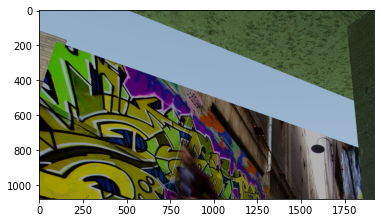

In [38]:
#Printing the training image

#image
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][0])
print(image.shape)
print(type(image))
plt.imshow(image)

image file name                         /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
component label file name               /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
damage label file name                  /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
depth image file name                   /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
camera focal length in mm                                                       43.242723
regular images                                                                       True
images containing damage in the RRDR                                                 True
Name: 3, dtype: object
(360, 640)
<class 'numpy.ndarray'>


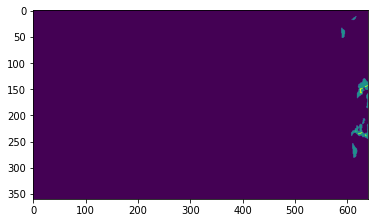

In [39]:
#label
#Printing the above image label
print(ftrain.iloc[3])
image = mpimg.imread(ftrain.iloc[3][2])#[x][y] x = row no. & y = {0:raw image, 1:component label, 2:damage label, 3:depth label}
print(image.shape)
print(type(image))
plt.imshow(image)

In [40]:
#Loading the training data from the pure_tex file

#Access the csv file containing the absolute directory paths to each file

col_names = ['image file name', 'damage label file name']

ftrain_tex = pd.read_csv(os.path.join(path_ds,'files_puretex_train.csv'),names = col_names,delimiter=',')
ftrain_tex.iloc[:,0] = ftrain_tex.iloc[:,0].apply(lambda x: path_correct(x))
ftrain_tex.iloc[:,1] = ftrain_tex.iloc[:,1].apply(lambda x: path_correct(x))

train_dmg_tex = ftrain_tex

In [41]:
train_dmg_tex

,image file name,damage label file name
0,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
1,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
2,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
3,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
4,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
...,...,...
2695,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
2696,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
2697,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
2698,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...


image file name           /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
damage label file name    /content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...
Name: 2, dtype: object
(360, 640)
<class 'numpy.ndarray'>


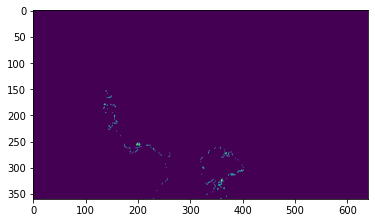

In [42]:
#Printing the training image
print(ftrain_tex.iloc[2])
image = mpimg.imread(ftrain_tex.iloc[2][1])
print(image.shape)
print(type(image))
plt.imshow(image)

In [43]:
#splitting the data for training and validation and also joining the dataset of both texture and component demage

#Run for training on the damage images
train1 = train_dmg[:1500]
val1 = train_dmg[2000:2800]
#train1 = train_dmg[:4000]
#val1 = train_dmg[4000:]

#appending texture images to the training and validation dataset
#train1 = train1.append(train_dmg_tex[:2300])
#val1 = val1.append(train_dmg_tex[2300:])

In [44]:
train1

,image file name,component label file name,damage label file name,depth image file name,camera focal length in mm
0,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,43.375470
3,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,43.242723
5,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,20.921244
7,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,46.639972
11,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,53.623157
...,...,...,...,...,...
4824,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,35.456138
4826,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,30.588883
4827,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,49.634743
4829,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,/content/drive/MyDrive/IC-SHM 2021/Tokaido_dat...,22.021498


In [45]:
# Creating the tf dataset from dataframe containing image addresses

images = train1['image file name'].to_numpy()
masks = train1['damage label file name'].to_numpy()
dataset = tf_dataset(images, masks)
images_val = val1['image file name'].to_numpy()
masks_val = val1['damage label file name'].to_numpy()
dataset_val = tf_dataset(images_val, masks_val)

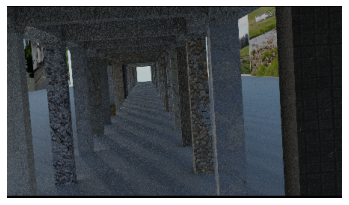

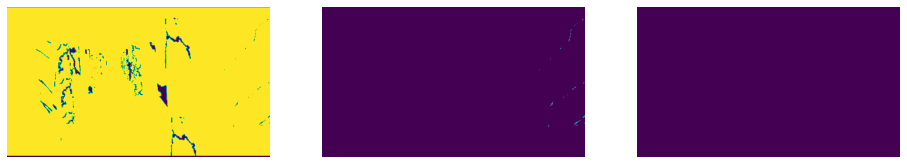

In [46]:
#Printing out an image for reference
for x, y in dataset.take(2):
        show_img(x[0])
        show_label(y[0])
        
        break 

In [72]:
#number of features to be used in the model df for encoder and uf for decoder, 32 was found to be optimal for both
df=32
uf=32
    
def build_unet(input_shape):

  # Inception Module
  def inception_block(inputs, num_filters=32):
    x = Conv2D(num_filters, 1, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x1 = Conv2D(num_filters, 1, padding="same")(inputs)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)
    x1 = Conv2D(num_filters, 3, padding="same")(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation("relu")(x1)

    x2 = Conv2D(num_filters, 1, padding="same")(inputs)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)
    x2 = Conv2D(num_filters, (3,1), padding="same")(x2)
    x2 = Conv2D(num_filters, (1,3), padding="same")(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation("relu")(x2)

    x3 = MaxPool2D((3,3), strides=(1,1), padding="same")(inputs)
    x3 = Conv2D(num_filters, 1, padding="same")(x3)
    x3 = BatchNormalization()(x3)
    x3 = Activation("relu")(x3)

    inception_module = Concatenate(axis=3)([x, x1, x2, x3])
    
    return inception_module

  # Convolution block
  def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

  # encoder block
  def encoder_block(input, num_filters):
    x = inception_block(input, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

  # Decoder block
  def decoder_block(input, skip_features, num_filters):
      x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
      x = Concatenate()([x, skip_features])
      x = conv_block(x, num_filters)
      return x

  #convolution block with batch normalization to be used in both encoder and decoder

  def conv2d(layer_input,filters,dropout_rate=0):
    d = Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
      
    d = Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)

    d = Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
    d = BatchNormalization()(d)

    sc = Conv2D(filters,kernel_size=(1,1),padding='same')(layer_input)
    sc = BatchNormalization()(sc)

    rp = Add()([sc,d])
    rp = Activation('relu')(rp)
    rp = Dropout(dropout_rate)(rp)
      
    return rp


  #"Source: https://github.com/srihari-humbarwadi/DeepLabV3_Plus-Tensorflow2.0/blob/master/deeplab.py"
  #ASPP


  def Upsample(tensor, size):
    '''bilinear upsampling'''
    name = tensor.name.split('/')[0] + '_upsample'

    def bilinear_upsample(x, size):
        resized = tf.image.resize(
            images=x, size=size)
        return resized
    y = Lambda(lambda x: bilinear_upsample(x, size),
               output_shape=size, name=name)(tensor)
    return y
  
  def ASPP(tensor):
    '''atrous spatial pyramid pooling'''
    dims = K.int_shape(tensor)

    y_pool = AveragePooling2D(pool_size=(
        dims[1], dims[2]), name='average_pooling')(tensor)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same',
                    kernel_initializer='he_normal', name='pool_1x1conv2d', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)

    y_pool = Upsample(tensor=y_pool, size=[dims[1], dims[2]])

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d1', use_bias=False)(tensor)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',
                 kernel_initializer='he_normal', name='ASPP_conv2d_d6', use_bias=False)(tensor)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d12', use_bias=False)(tensor)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same',
                  kernel_initializer='he_normal', name='ASPP_conv2d_d18', use_bias=False)(tensor)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y = concatenate([y_pool, y_1, y_6, y_12, y_18], name='ASPP_concat')

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
               kernel_initializer='he_normal', name='ASPP_conv2d_final', use_bias=False)(y)
    y = BatchNormalization(name=f'bn_final')(y)
    y = Activation('relu', name=f'relu_final')(y)
    return y




  #actual model definition depth = 4, i.e. 4 times downsampled by factor of 2 (by maxpooling)

  inputs = Input(input_shape)
    
  s1, p1 = encoder_block(inputs, 64)

  s2, p2 = encoder_block(p1, 128)

  # s3, p3 = encoder_block(p2, 256)

  p3 = ASPP(p2)
  s3 = conv2d(p3, 256)
  # p4 = ASPP(p3)
  # s4 = conv2d(p4, 512)

  # d1 = decoder_block(s4, s3, 256)

  d2 = decoder_block(s3, s2, 128)

  d3 = decoder_block(d2, s1, 64)

  #here the first input to Conv2D i.e. 3 defines the output number of classes to be pridicted

  outputs = Conv2D(3,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d3)
   
  model = Model(inputs=inputs,outputs=outputs)
    
  return model

In [73]:
#building the unet model with gated attention and residual connections and printing its summary
model = build_unet((256,448,3))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_85 (Conv2D)             (None, 256, 448, 64  256         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_83 (Conv2D)             (None, 256, 448, 64  256         ['input_4[0][0]']                
                                )                                                           

In [74]:
#using Adam optimizer and fixing the learning rate 
optimizer_adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

In [75]:
#Checkpoint for model saving and reloading the saved weights
# "training_dmg_resatt_final/cp_dmg.ckpt" this checkpoint to be supplied for best weights as trained by us
ck_path = os.path.join('/content/drive/MyDrive/summer_intern','damage_cps')
checkpoint_path = os.path.join(ck_path, "my_checkpoint.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)


cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,  monitor = 'iou', mode='max', save_best_only = True,
                                                 verbose=1)

In [76]:
""" Courtesy stackoverflow Daniel Möller https://stackoverflow.com/users/2097240/daniel-m%c3%b6ller?tab=profile
answer to question 'Custom loss function for U-net in keras using class weights: `class_weight` not supported for 3+ dimensional targets' 
"""
# Weighted loss function 
def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis)
        classSelectors = tf.cast(classSelectors, tf.int32) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [77]:
#summation of dice loss and cross entropy loss

from keras import backend as K
def DiceCELoss(targets, inputs, smooth=1e-6):
    CE = tf.keras.metrics.binary_crossentropy(targets, inputs)
    y_true_f=K.flatten(targets)
    y_pred_f=K.flatten(inputs)
    intersection=K.sum(y_true_f*y_pred_f)
    dice_loss=1-((2*intersection) + smooth)/(K.sum(y_true_f*y_true_f)+K.sum(y_pred_f*y_pred_f)+ smooth)
    dice_CE=dice_loss+CE
    return dice_CE

In [78]:
#summation of log of (1-dice loss) and cross entropy loss

import math
from keras import backend as K
def logDiceCELoss(targets, inputs, smooth=1e-6):
    CE = tf.keras.metrics.binary_crossentropy(targets, inputs)
    #CE = tf.keras.metrics.CategoricalCrossentropy(targets, inputs)
    y_true_f=K.flatten(targets)
    y_pred_f=K.flatten(inputs)
    intersection=K.sum(y_true_f*y_pred_f)
    dice_loss=1-((2*intersection) + smooth)/(K.sum(y_true_f*y_true_f)+K.sum(y_pred_f*y_pred_f)+ smooth)
    dice_CE=CE-math.log(1-dice_loss)
    return dice_CE

In [79]:
# The weights for each class are hardcoded here and are calculated using the code presented towards the end of this notebook
w1= 0.03611688490088685
w2= 1.0
w3=9.345573778790564

In [80]:
#best results were obtained with binary cross entropy loss

model.compile(optimizer= optimizer_adam,
              loss= weightedLoss(tf.keras.losses.BinaryCrossentropy(), [w1,w2,w3]),
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.Recall(thresholds = 0.2),
                       tf.keras.metrics.Precision(thresholds = 0.7),
                       tf.keras.metrics.MeanIoU(3,name="iou")])

In [84]:
#run this cell for loading the weights from saved checkpoints
model.load_weights(checkpoint_path)

#**Training, Metrics and Validation**

In [85]:
#Train the model
history = model.fit(dataset, epochs= 20 ,validation_data= dataset_val, verbose = 1, callbacks=[cp_callback])

Epoch 1/20
188/188 [==============================] - ETA: 0s - loss: 0.0196 - binary_accuracy: 0.9823 - recall_3: 0.9866 - precision_3: 0.9841 - iou: 0.3381
Epoch 1: iou did not improve from 0.33810
188/188 [==============================] - 346s 2s/step - loss: 0.0196 - binary_accuracy: 0.9823 - recall_3: 0.9866 - precision_3: 0.9841 - iou: 0.3381 - val_loss: 0.0203 - val_binary_accuracy: 0.9823 - val_recall_3: 0.9823 - val_precision_3: 0.9819 - val_iou: 0.3381
Epoch 2/20
188/188 [==============================] - ETA: 0s - loss: 0.0156 - binary_accuracy: 0.9832 - recall_3: 0.9803 - precision_3: 0.9810 - iou: 0.3381
Epoch 2: iou did not improve from 0.33810
188/188 [==============================] - 349s 2s/step - loss: 0.0156 - binary_accuracy: 0.9832 - recall_3: 0.9803 - precision_3: 0.9810 - iou: 0.3381 - val_loss: 0.0163 - val_binary_accuracy: 0.9821 - val_recall_3: 0.9796 - val_precision_3: 0.9807 - val_iou: 0.3381
Epoch 3/20
188/188 [==============================] - ETA: 0s - 

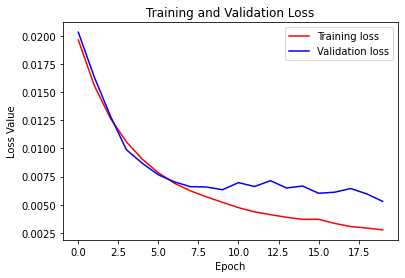

In [86]:
#Print Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

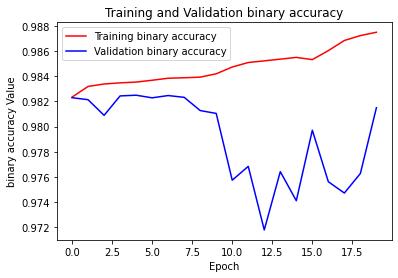

In [87]:
#Print Binary Accuracy
accu = history.history['binary_accuracy']
val_accu = history.history['val_binary_accuracy']

plt.figure()
plt.plot(history.epoch, accu, 'r', label='Training binary accuracy')
plt.plot(history.epoch, val_accu, 'b', label='Validation binary accuracy')
plt.title('Training and Validation binary accuracy')
plt.xlabel('Epoch')
plt.ylabel('binary accuracy Value')
plt.legend()
plt.show()

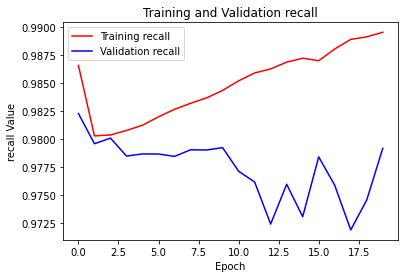

In [89]:
#print recall
recall = history.history['recall_3']
val_recall = history.history['val_recall_3']

plt.figure()
plt.plot(history.epoch, recall, 'r', label='Training recall')
plt.plot(history.epoch, val_recall, 'b', label='Validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epoch')
plt.ylabel('recall Value')
plt.legend()
plt.show()

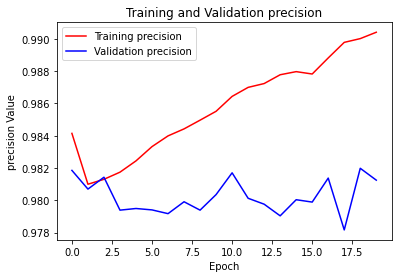

In [90]:
#Print precision
pres = history.history['precision_3']
val_pres = history.history['val_precision_3']

plt.figure()
plt.plot(history.epoch, pres, 'r', label='Training precision')
plt.plot(history.epoch, val_pres, 'b', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epoch')
plt.ylabel('precision Value')
plt.legend()
plt.show()

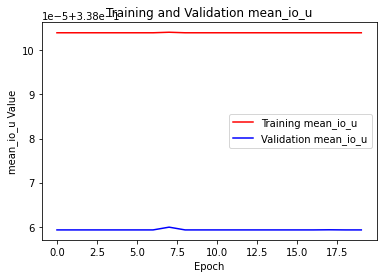

In [92]:
#Print Mean IoU
miou = history.history['iou']
val_miou = history.history['val_iou']

plt.figure()
plt.plot(history.epoch, miou, 'r', label='Training mean_io_u')
plt.plot(history.epoch, val_miou, 'b', label='Validation mean_io_u')
plt.title('Training and Validation mean_io_u')
plt.xlabel('Epoch')
plt.ylabel('mean_io_u Value')
plt.legend()
plt.show()

In [93]:
#Evaluate the model on validation dataset
model.evaluate(dataset_val, verbose = 1)

100/100 [==============================] - 53s 528ms/step - loss: 0.0053 - binary_accuracy: 0.9815 - recall_3: 0.9792 - precision_3: 0.9813 - iou: 0.3381


[0.005306791048496962,
 0.9814925789833069,
 0.9791662693023682,
 0.9812505841255188,
 0.33805927634239197]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


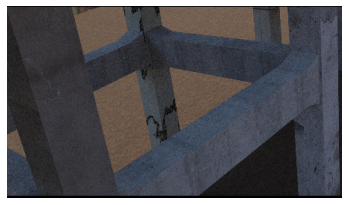

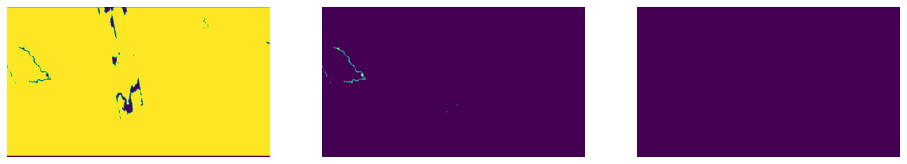

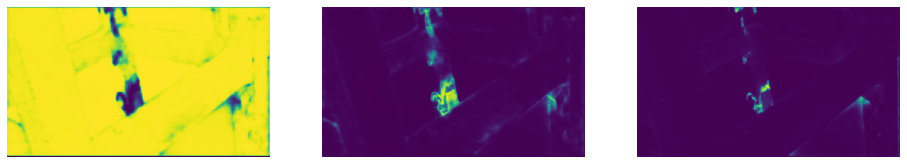

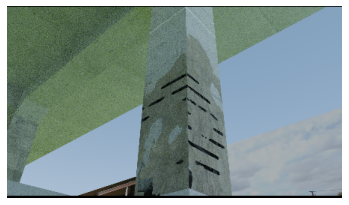

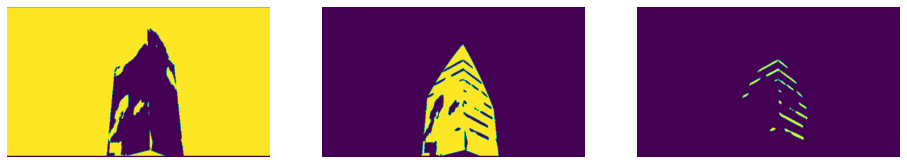

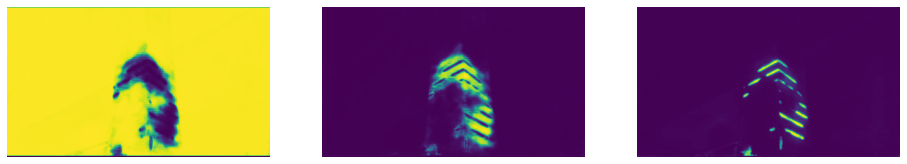

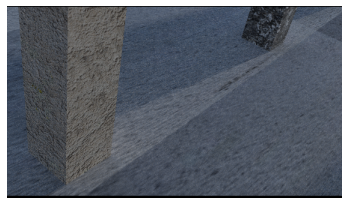

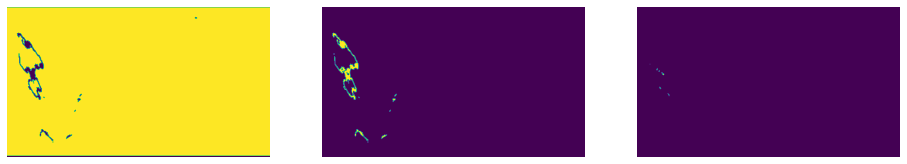

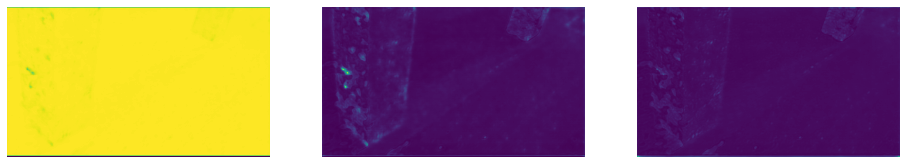

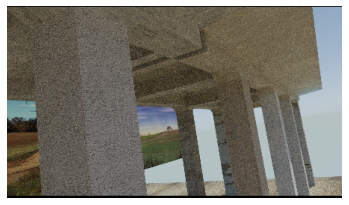

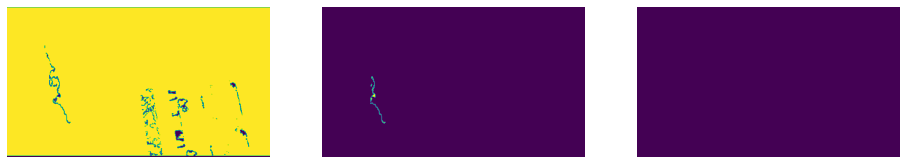

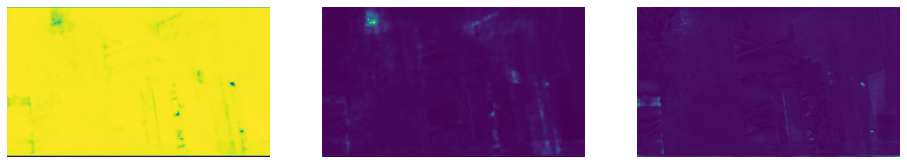

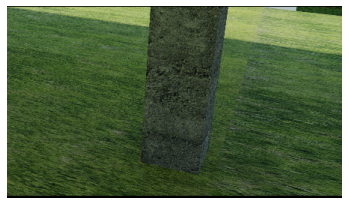

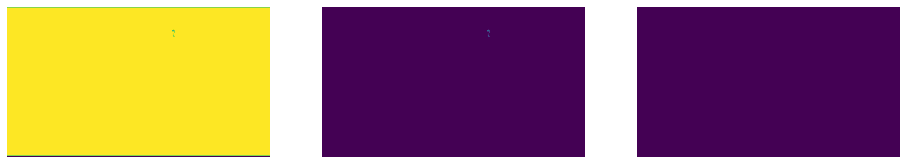

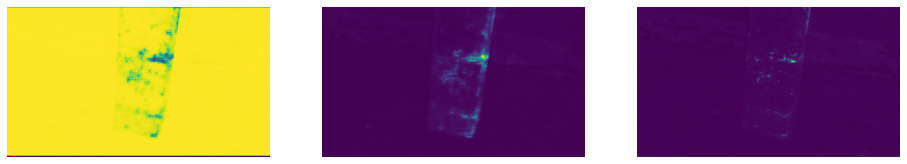

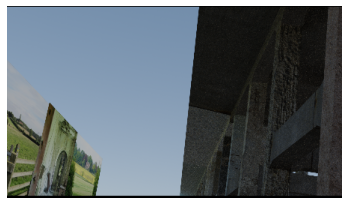

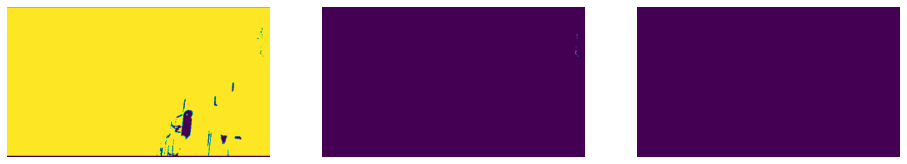

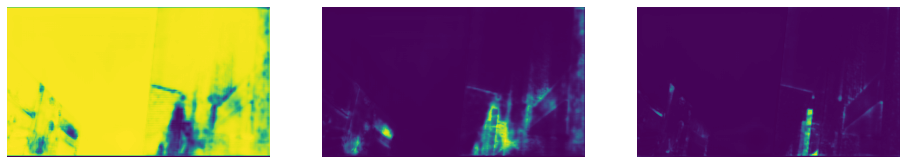

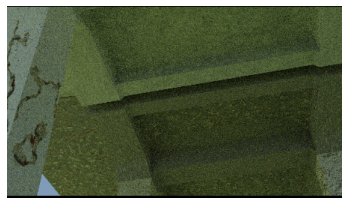

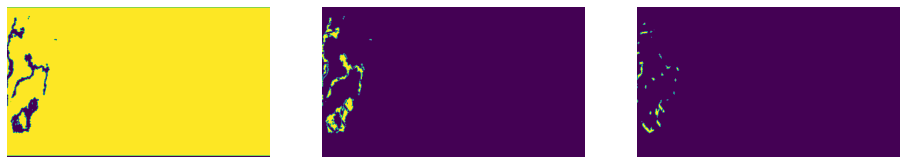

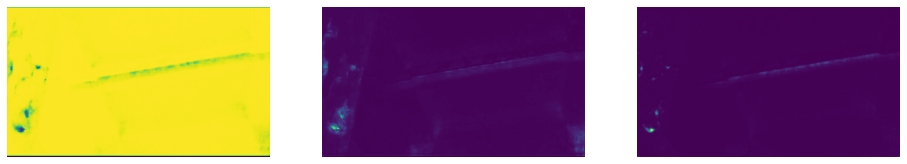

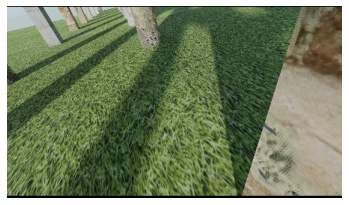

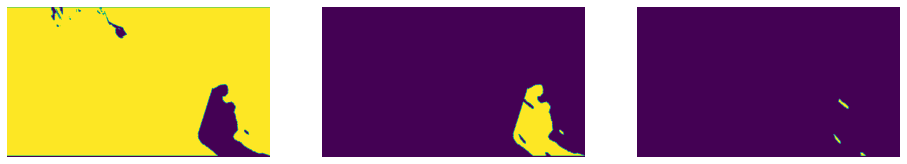

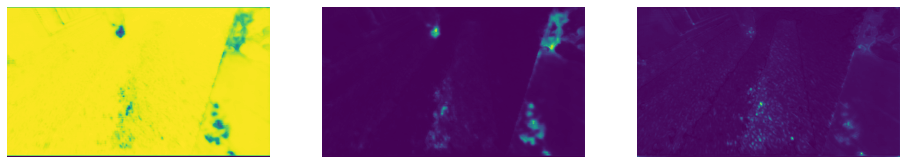

In [94]:
#Printing predictions on the validation dataset
z=1
for x, y in dataset_val.take(10):
        z += 1
        show_img(x[2])
        show_label(y[2])
        pred = model.predict(x)
        show_pred(pred[2])
        if (z==9):
          break

#**Testing**

In [95]:
#Preprocessing for the test dataset
def preprocess_test(x,y):
    def f(x,y):
        x = tf.io.read_file(x)
        y = tf.io.read_file(y)
        x = tf.io.decode_png(x, channels = 3)
        x = tf.image.resize_with_pad(x, 256,448)
        x = tf.numpy_function(normalize, [x], [tf.float32]) 
        y = tf.io.decode_png(y, channels = 0)   
        y = tf.numpy_function(get_label_tex, [y], [tf.float32])
        y = tf.image.resize_with_pad(y, 256, 448)   

        return x, y

    images, masks = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([256, 448, 3])
    masks.set_shape([256, 448, 3])

    return images, masks

In [96]:
#dataloader for the test dataset
def tf_dataset_test(x,y, batch = 8):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess_test, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.batch(batch, num_parallel_calls= tf.data.AUTOTUNE)
    dataset = dataset.cache()
    return dataset

In [97]:
#Function to change the path format 
def path_correct_png(path):
  path = '/'.join(path[2:].split('\\'))
  path = os.path.join(path_ds, path)
  path = path[:-4] + '.png'
  return path

In [98]:
#Loading the training data from the pure_tex file

#Access the csv file containing the absolute directory paths to each file

col_names = ['image file name', 'damage label file name']

ftest = pd.read_csv(os.path.join(path_ds,'files_puretex_test.csv'),names = col_names,delimiter=',')
ftest.iloc[:,0] = ftest.iloc[:,0].apply(lambda x: path_correct(x))
ftest.iloc[:,1] = ftest.iloc[:,1].apply(lambda x: path_correct_png(x))

test_dmg_tex = ftest

In [99]:
# creating dataloader for texture images
images_test = test_dmg_tex['image file name'].to_numpy()
masks_test = test_dmg_tex['damage label file name'].to_numpy()
dataset_test_tex = tf_dataset_test(images_test,masks_test)
address_tex = test_dmg_tex['damage label file name'].apply(lambda x : os.path.split(x)[1]).to_numpy()

In [100]:
#Printing predictions on the texture test dataset
z=1
for x, y in dataset_test_tex.take(10):
        z += 1
        show_img(x[2])
        show_label(y[2])
        pred = model.predict(x)
        show_pred(pred[2])
        if (z==9):
          break

UnknownError: ignored

In [ ]:
# Loading the testing data from the component demage test dataset file

#Access the csv file containing the absolute directory paths to each file

col_names = ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 
             'camera focal length in mm', 'regular images', 'images containing damage in the RRDR']
ftest = pd.read_csv(os.path.join(path_ds,'files_test.csv'),names = col_names,delimiter=',')
ftest.iloc[:,0] = ftest.iloc[:,0].apply(lambda x: path_correct(x))
ftest.iloc[:,1] = ftest.iloc[:,1].apply(lambda x: path_correct(x))
ftest.iloc[:,2] = ftest.iloc[:,2].apply(lambda x: path_correct_png(x))
ftest.iloc[:,3] = ftest.iloc[:,3].apply(lambda x: path_correct(x))
test_comp = ftest.loc[ftest['images containing damage in the RRDR']==True, ['image file name', 'component label file name', 'damage label file name', 'depth image file name', 'camera focal length in mm']]


In [ ]:
# creating dataloader for component damage images

images_test = test_comp['image file name'].to_numpy()
masks_test = test_comp['damage label file name'].to_numpy()
dataset_test = tf_dataset_test(images_test,masks_test)
address = test_comp['damage label file name'].apply(lambda x : os.path.split(x)[1]).to_numpy()

In [ ]:
#Printing predictions on the component damage test dataset
z=1
for x, y in dataset_test.take(10):
        z += 1
        show_img(x[0])
        show_label(y[0])
        pred = model.predict(x)
        show_pred(pred[0])
        if (z==9):
          break